# NBA Viewer Prediction

This is the work and thoughts while building our model to predict viewership for the NBA.

# Imports

In [488]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [489]:
import numpy as np 
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Read Data

In [490]:
game_data = pd.read_csv("game_data.csv")
player_data = pd.read_csv("player_data.csv")
training_data = pd.read_csv("training_set.csv", parse_dates = ['Game_Date'])

In [491]:
training_data.head()

Season   Game_ID  Game_Date Away_Team Home_Team Country  Rounded Viewers
0  2016-17  21600001 2016-10-25       NYK       CLE    C113               18
1  2016-17  21600001 2016-10-25       NYK       CLE    C193                1
2  2016-17  21600001 2016-10-25       NYK       CLE    C126                4
3  2016-17  21600001 2016-10-25       NYK       CLE    C163               11
4  2016-17  21600001 2016-10-25       NYK       CLE     C73                3

In [492]:
training_data.columns

Index(['Season', 'Game_ID', 'Game_Date', 'Away_Team', 'Home_Team', 'Country',
       'Rounded Viewers'],
      dtype='object')

In [493]:
training_data.dtypes

Season                     object
Game_ID                     int64
Game_Date          datetime64[ns]
Away_Team                  object
Home_Team                  object
Country                    object
Rounded Viewers             int64
dtype: object

In [494]:
training_data.set_index("Game_ID", inplace = True)

First do some feature engineering on the dates, get the day of the week, and see average viewers on each day

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


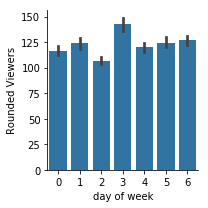

In [495]:
training_data['day of week'] = training_data.Game_Date.dt.dayofweek
g = sns.FacetGrid(training_data)
g.map(sns.barplot, 'day of week',  'Rounded Viewers')

Looks like Thursday has the higehst number of viewers, something to take note of would be the possible variables that make Thursday have the highest number of viewers

Next make sure our categorical variables are actually categorical

In [496]:
training_data.dtypes

Season                     object
Game_Date          datetime64[ns]
Away_Team                  object
Home_Team                  object
Country                    object
Rounded Viewers             int64
day of week                 int64
dtype: object

In [497]:
training_data['Away_Team'] = training_data['Away_Team'].astype('category').cat.as_ordered()
training_data['Home_Team'] = training_data['Home_Team'].astype('category').cat.as_ordered()
training_data.dtypes

Season                     object
Game_Date          datetime64[ns]
Away_Team                category
Home_Team                category
Country                    object
Rounded Viewers             int64
day of week                 int64
dtype: object

Add Weekend Data

In [498]:
training_data['weekend'] = np.where(training_data.Game_Date.dt.dayofweek > 3, 1, 0)

In [499]:
training_data.Away_Team.cat.categories

Index(['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW',
       'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK',
       'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'],
      dtype='object')

In [500]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [501]:
training_data.head()

Season  Game_Date Away_Team Home_Team Country  Rounded Viewers  \
Game_ID                                                                     
21600001  2016-17 2016-10-25       NYK       CLE    C113               18   
21600001  2016-17 2016-10-25       NYK       CLE    C193                1   
21600001  2016-17 2016-10-25       NYK       CLE    C126                4   
21600001  2016-17 2016-10-25       NYK       CLE    C163               11   
21600001  2016-17 2016-10-25       NYK       CLE     C73                3   

          day of week  weekend  
Game_ID                         
21600001            1        0  
21600001            1        0  
21600001            1        0  
21600001            1        0  
21600001            1        0

Lastly, we will only look at total viewers for now as it is what the test dataset is evalulated on. We may come back to look at countries later

In [502]:
training_data['Total_Views'] = training_data.groupby("Game_ID")["Rounded Viewers"].sum()

In [503]:
training_data.drop(['Rounded Viewers', 'Country'], inplace = True, axis = 1)
training_data.drop_duplicates(inplace = True)

Next make sure day of week and season are categorical. It shouldn't matter too much for random forests but it is good to be safe

In [504]:
training_data['Season'] = training_data['Season'].astype('category').cat.as_ordered()
training_data['day of week'] = training_data['day of week'].astype('category').cat.as_ordered()
training_data.dtypes

Season               category
Game_Date      datetime64[ns]
Away_Team            category
Home_Team            category
day of week          category
weekend                 int32
Total_Views             int64
dtype: object

In [505]:
training_data.Season = training_data.Season.cat.codes
training_data['day of week']= training_data['day of week'].cat.codes

In [506]:
print(training_data.head())

          Season  Game_Date Away_Team Home_Team  day of week  weekend  \
Game_ID                                                                 
21600001       0 2016-10-25       NYK       CLE            1        0   
21600003       0 2016-10-25       SAS       GSW            1        0   
21600002       0 2016-10-25       UTA       POR            1        0   
21600006       0 2016-10-26       BKN       BOS            2        0   
21600008       0 2016-10-26       CHA       MIL            2        0   

          Total_Views  
Game_ID                
21600001        57691  
21600003        60428  
21600002        40740  
21600006        23947  
21600008        12046  


In [507]:
def mape(x, y): return np.mean(np.abs((x - y) / y)) * 100

def randomforest(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Game_Date", "Total_Views"], axis = 1, inplace = True)
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
    randomforest = RandomForestRegressor(random_state = 0,  
                                         n_estimators=200, min_samples_leaf= 1, oob_score = True)
    randomforest.fit(train_X, train_y)
    res = [mape(randomforest.predict(train_X), train_y), mape(randomforest.predict(val_X), val_y), 
          randomforest.score(train_X, train_y), randomforest.score(val_X, val_y)]
    if hasattr(randomforest, 'oob_score_'): res.append(randomforest.oob_score_)
    print(res)

    

# one hot encoding

In [508]:
training_data = pd.get_dummies(training_data, columns = ['Home_Team', 'Away_Team'])

In [509]:
%time randomforest(training_data)

[14.605570067961759, 38.15240201016578, 0.92485752751278294, 0.5272242135475278, 0.49493011749766402]
Wall time: 2.2 s


With these limited columns, our data is definetly extremely overfitted. The Mape is only 18% for the training data, but 46% for the validation. The r^2 shows the same. We will add more variables to help combat this

All-Star Data

In [510]:
player_data['AllStar'] = np.where(player_data.ASG_Team != "None", 1, 0)
player_data.set_index('Game_ID', inplace = True)
allstar = player_data.groupby('Game_ID')['AllStar'].sum()
training_data['AllStar'] = allstar
del allstar

In [511]:
g = sns.FacetGrid(training_data)

g.map(sns.barplot, 'AllStar',  'Total_Views')

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Clearly a decent relationship between number of all stars in a game and the total viewers

Try adding population of cities to the teams

In [512]:
population_of_city = {'CLE': 2055612, 'NYK': 10153634, 'POR': 2424955,'UTA': 1186187, 'GSW': 4679166, 'SAS': 2429609, 'MIA':  6066387,
                     'ORL': 2441257, 'DAL': 7233323, 'IND': 2004230, 'BOS': 4794447, 'BKN': 10000000, 'TOR': 5928040, 'DET': 4297617,
                     'MIL': 1572482, 'MEM': 1342842, 'NOP': 1268883, 'DEN': 2853077, 'PHI': 6070500, 'OKC': 1373211, 'PHX': 4661537, 
                     'SAC': 2296418, 'HOU': 6772470, 'LAL': 13310447, 'ATL': 5789700, 'WAS': 6131977, 'CHI': 9512999, 'LAC': 13310446,
                     'CHA': 2474314, 'MIN': 3551036 }


game_data['Team_population'] = game_data['Team'].map(population_of_city)
game_data.columns

Index(['Season', 'Game_ID', 'Game_Date', 'Team', 'Location',
       'Wins_Entering_Gm', 'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score',
       'Lead_Changes', 'Ties', 'Largest_Lead', 'Full_Timeouts',
       'Short_Timeouts', 'Qtr_4_Score', 'L2M_Score', 'Team_population'],
      dtype='object')

In [513]:
training_data['Total_population'] = game_data.groupby('Game_ID')['Team_population'].sum()

In [514]:
randomforest(training_data)

[14.989728602956061, 37.990254667698252, 0.9269040507214007, 0.55912048367356215, 0.50900103717476797]


not much of a change, may try to get rid of this later on

In [515]:
game_data.set_index('Game_ID', inplace = True)
training_data['Home_team_population']= game_data.loc[game_data['Location'] == 'H', ['Team_population']]

In [516]:
randomforest(training_data)

[15.154920062774718, 38.23523863508241, 0.92600990330585642, 0.56115156907290509, 0.50252382874394552]


In [517]:
randomforest(training_data.drop(['Total_population', 'Home_team_population'], axis = 1))

[14.500031964387771, 38.106117656192716, 0.92756602279471556, 0.55458369783549155, 0.51336576393682454]


We will drop total and home team population for now as it seems to have no effect

In [518]:
training_data.drop(['Total_population', 'Home_team_population'], axis = 1, inplace = True)

Adding some information about first game/first week

In [519]:
game_data['Total_games'] = game_data[[ 'Wins_Entering_Gm', 'Losses_Entering_Gm']].sum(axis = 1)
game_data['First_game'] = np.where(game_data['Total_games'] == 0, 1, 0)
game_data['First_week'] = np.where(game_data['Total_games'] < 3, 1, 0)

In [520]:
training_data['First_game'] = game_data.loc[game_data['Location'] == 'H', ['First_game']]
training_data['First_week'] = game_data.loc[game_data['Location'] == 'H', ['First_week']]

In [521]:
randomforest(training_data)

[13.741518392790145, 35.260476358203469, 0.93619851013168776, 0.6200047724465515, 0.5659499050556176]


In [522]:
training_data['Total_games_home'] = game_data.loc[game_data['Location'] == 'H', ['Total_games']]
training_data['Total_games_away'] = game_data.loc[game_data['Location'] == 'A', ['First_game']]


In [523]:
randomforest(training_data)

[12.240230223595791, 32.70780481337232, 0.95130523332702632, 0.65114482116239281, 0.64230960509445723]


In [524]:
game_data['last_5_games'] = np.where(game_data['Total_games'] > 76, 1, 0)
training_data['last_5_games'] = game_data.loc[game_data['Location'] == 'H', ['last_5_games']]
sns.barplot(x = 'last_5_games', y = 'Total_Views', data = training_data)

In [525]:
randomforest(training_data)

[12.209167686191895, 32.659299396596815, 0.95145794673473461, 0.65204119727701482, 0.64344274388286626]


In [526]:
training_data.drop('last_5_games', axis = 1, inplace = True)

Adding past ranking in conference

In [527]:
rankinginconference = {'CLE': 1, 'NYK': 3, 'POR': 3,'UTA': 1, 'GSW': 1, 'SAS': 3, 'MIA': 3,
                     'ORL': 5, 'DAL': 5, 'IND': 3, 'BOS': 1, 'BKN': 5 , 'TOR': 2, 'DET': 5,
                     'MIL': 2, 'MEM': 3, 'NOP': 4, 'DEN': 4, 'PHI': 4, 'OKC': 2, 'PHX': 5, 
                     'SAC': 3, 'HOU': 2, 'LAL': 4, 'ATL': 2, 'WAS': 1, 'CHI': 4, 'LAC': 4,
                     'CHA': 4, 'MIN': 5 }


game_data['ranking'] = game_data['Team'].map(rankinginconference)
game_data.columns

Index(['Season', 'Game_Date', 'Team', 'Location', 'Wins_Entering_Gm',
       'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score', 'Lead_Changes',
       'Ties', 'Largest_Lead', 'Full_Timeouts', 'Short_Timeouts',
       'Qtr_4_Score', 'L2M_Score', 'Team_population', 'Total_games',
       'First_game', 'First_week', 'last_5_games', 'ranking'],
      dtype='object')

In [528]:
training_data['home_ranking'] = game_data.loc[game_data['Location'] == 'H', ['ranking']]
training_data['away_ranking'] = game_data.loc[game_data['Location'] == 'A', ['ranking']]

In [529]:
randomforest(training_data)

[12.315446143409661, 32.696384577090967, 0.9526711586028157, 0.65713331790087937, 0.65093911138860272]


In [530]:
def xgboost(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Game_Date", "Total_Views"], axis = 1, inplace = True)
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
    xgb = XGBRegressor(n_estimators=500)
    xgb.fit(train_X, train_y)
    res = [mape(xgb.predict(train_X), train_y), mape(xgb.predict(val_X), val_y), 
          xgb.score(train_X, train_y), xgb.score(val_X, val_y)]
    if hasattr(xgb, 'oob_score_'): res.append(xgb.oob_score_)
    print(res)

In [531]:
xgboost(training_data)

[19.65983529313355, 29.400054210818134, 0.91267101993455202, 0.74257013710589281]


In [532]:
X = training_data.copy()
y = X['Total_Views']
X.drop(["Game_Date", "Total_Views"], axis = 1, inplace = True)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
rf = RandomForestRegressor(random_state = 0,  
                                         n_estimators=200, min_samples_leaf= 1, oob_score = True)
rf.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [533]:
def print_score(m):
    res = [mape(m.predict(train_X), train_y), mape(m.predict(val_X), val_y), 
          m.score(train_X, train_y), m.score(val_X, val_y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [534]:
print_score(rf)

[12.315446143409661, 32.696384577090967, 0.9526711586028157, 0.65713331790087937, 0.65093911138860272]


In [535]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [536]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                    ).sort_values('imp', ascending=False)

In [537]:
fi = rf_feat_importance(rf, train_X)

In [538]:
fi[:10]

cols       imp
63           AllStar  0.354220
66  Total_games_home  0.168105
38     Away_Team_CLE  0.051731
8      Home_Team_CLE  0.034879
1        day of week  0.033604
69      away_ranking  0.025023
68      home_ranking  0.023032
23     Home_Team_OKC  0.021234
16     Home_Team_LAL  0.020638
0             Season  0.018794

According to this... All Stars is a pretty big factor in viewers. We should probably be looking at players instead of teams/dayofweek info. 

In [539]:
player_data.head()

Season   Game_Date Team  Person_ID              Name  ASG_Team  \
Game_ID                                                                     
21600001  2016-17  10/25/2016  CLE     101112     Channing Frye      None   
21600001  2016-17  10/25/2016  CLE     201567        Kevin Love  East ASG   
21600001  2016-17  10/25/2016  CLE     202681      Kyrie Irving  East ASG   
21600001  2016-17  10/25/2016  CLE     202684  Tristan Thompson      None   
21600001  2016-17  10/25/2016  CLE     202697     Iman Shumpert      None   

         Active_Status  Minutes  Points  Defensive_Rebounds   ...     Blocks  \
Game_ID                                                       ...              
21600001        Active     14.0     6.0                 2.0   ...        1.0   
21600001        Active     25.0    23.0                10.0   ...        0.0   
21600001        Active     30.0    29.0                 1.0   ...        0.0   
21600001        Active     22.0     0.0                 4.0   ...        0.0   
21600001        Active     14.0     2.0                 1.0   ...        1.0   

          Turnovers  Field_Goals  Field_Goals_Attempted  Three_Pointers  \
Game_ID                                                                   
21600001        1.0          2.0                    6.0             2.0   
21600001        2.0          6.0                   15.0             2.0   
21600001        0.0         12.0                   22.0             4.0   
21600001        2.0          0.0                    1.0             0.0   
21600001        2.0          1.0                    3.0             0.0   

          Three_Pointers_Attempted  Free_Throws  Free_Throws_Attempted  \
Game_ID                                                                  
21600001                       5.0          0.0                    0.0   
21600001                       6.0          9.0                   12.0   
21600001                       7.0          1.0                    1.0   
21600001                       0.0          0.0                    0.0   
21600001                       1.0          0.0                    0.0   

          Personal_Fouls  AllStar  
Game_ID                            
21600001             4.0        0  
21600001             3.0        1  
21600001             1.0        1  
21600001             4.0        0  
21600001             2.0        0  

[5 rows x 23 columns]

In [540]:
fi [:20]

cols       imp
63           AllStar  0.354220
66  Total_games_home  0.168105
38     Away_Team_CLE  0.051731
8      Home_Team_CLE  0.034879
1        day of week  0.033604
69      away_ranking  0.025023
68      home_ranking  0.023032
23     Home_Team_OKC  0.021234
16     Home_Team_LAL  0.020638
0             Season  0.018794
46     Away_Team_LAL  0.018396
53     Away_Team_OKC  0.016623
35     Away_Team_BOS  0.014730
25     Home_Team_PHI  0.014522
43     Away_Team_HOU  0.013498
5      Home_Team_BOS  0.011127
59     Away_Team_SAS  0.010670
29     Home_Team_SAS  0.008458
13     Home_Team_HOU  0.006635
2            weekend  0.006331

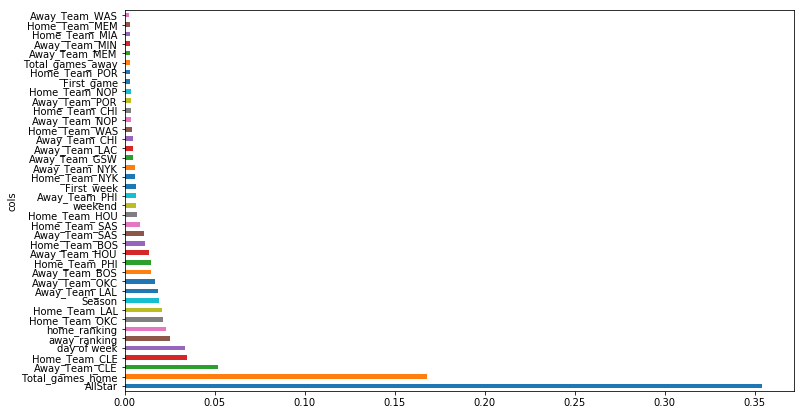

In [541]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:40]);

In [542]:
rf = RandomForestRegressor(random_state = 0, 
                                         n_estimators=300, min_samples_leaf= 1, oob_score = True)
rf.fit(train_X, train_y)
print_score(rf)

[12.278275377435936, 32.729970488243282, 0.95279012602596758, 0.65727467512291393, 0.6526100365073646]


In [543]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
to_keep

63             AllStar
66    Total_games_home
38       Away_Team_CLE
8        Home_Team_CLE
1          day of week
69        away_ranking
68        home_ranking
23       Home_Team_OKC
16       Home_Team_LAL
0               Season
46       Away_Team_LAL
53       Away_Team_OKC
35       Away_Team_BOS
25       Home_Team_PHI
43       Away_Team_HOU
5        Home_Team_BOS
59       Away_Team_SAS
29       Home_Team_SAS
13       Home_Team_HOU
2              weekend
55       Away_Team_PHI
65          First_week
22       Home_Team_NYK
52       Away_Team_NYK
Name: cols, dtype: object

In [544]:
X = training_data.copy()
y = X['Total_Views']
X.drop(["Game_Date", "Total_Views"], axis = 1, inplace = True)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
rf = RandomForestRegressor(random_state = 0,  
                                         n_estimators=200, min_samples_leaf= 1, oob_score = True)
rf.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [545]:
print_score(rf)

[12.315446143409661, 32.696384577090967, 0.9526711586028157, 0.65713331790087937, 0.65093911138860272]


First some data from https://www.statista.com/statistics/322941/facebook-fans-twitter-followers-of-nba/

In [546]:
nba_followers = {'CLE': 3.16, 'NYK': 2.07, 'POR': 1.13,'UTA': 0.79, 'GSW': 5.63, 'SAS': 3.32, 'MIA':  4.68,
                     'ORL': 1.59, 'DAL': 0.79, 'IND': 1.11, 'BOS': 3.21, 'BKN': 0.88, 'TOR': 1.5, 'DET': 0.85,
                     'MIL': 0.87, 'MEM': 0.92, 'NOP': 0.8, 'DEN': 0.79, 'PHI': 1.46, 'OKC': 2.55, 'PHX': 0.99, 
                     'SAC': 0.96, 'HOU': 2.54, 'LAL': 7.39, 'ATL': 1.19, 'WAS': 0.85, 'CHI': 4.09, 'LAC': 1.37,
                     'CHA': 0.88, 'MIN': 0.85 }


game_data['nba_followers'] = game_data['Team'].map(nba_followers)
game_data.columns

Index(['Season', 'Game_Date', 'Team', 'Location', 'Wins_Entering_Gm',
       'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score', 'Lead_Changes',
       'Ties', 'Largest_Lead', 'Full_Timeouts', 'Short_Timeouts',
       'Qtr_4_Score', 'L2M_Score', 'Team_population', 'Total_games',
       'First_game', 'First_week', 'last_5_games', 'ranking', 'nba_followers'],
      dtype='object')

In [547]:
training_data['nba_followers'] = game_data.groupby('Game_ID')['nba_followers'].sum()

In [548]:
training_data.head()

Season  Game_Date  day of week  weekend  Total_Views  Home_Team_ATL  \
Game_ID                                                                         
21600001       0 2016-10-25            1        0        57691              0   
21600003       0 2016-10-25            1        0        60428              0   
21600002       0 2016-10-25            1        0        40740              0   
21600006       0 2016-10-26            2        0        23947              0   
21600008       0 2016-10-26            2        0        12046              0   

          Home_Team_BKN  Home_Team_BOS  Home_Team_CHA  Home_Team_CHI  \
Game_ID                                                                
21600001              0              0              0              0   
21600003              0              0              0              0   
21600002              0              0              0              0   
21600006              0              1              0              0   
21600008              0              0              0              0   

              ...        Away_Team_UTA  Away_Team_WAS  AllStar  First_game  \
Game_ID       ...                                                            
21600001      ...                    0              0        4           1   
21600003      ...                    0              0        5           1   
21600002      ...                    1              0        1           1   
21600006      ...                    0              0        1           1   
21600008      ...                    0              0        2           1   

          First_week  Total_games_home  Total_games_away  home_ranking  \
Game_ID                                                                  
21600001           1                 0                 1             1   
21600003           1                 0                 1             1   
21600002           1                 0                 1             3   
21600006           1                 0                 1             1   
21600008           1                 0                 1             2   

          away_ranking  nba_followers  
Game_ID                                
21600001             3           5.23  
21600003             3           8.95  
21600002             1           1.92  
21600006             5           4.09  
21600008             4           1.75  

[5 rows x 73 columns]

In [549]:
g = sns.FacetGrid(training_data)
g.map(sns.barplot, 'nba_followers',  'Total_Views')

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [550]:
X = training_data.copy()
y = X['Total_Views']
X.drop(["Game_Date", "Total_Views"], axis = 1, inplace = True)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
rf = RandomForestRegressor(random_state = 0,  
                                         n_estimators=200, min_samples_leaf= 1, oob_score = True)
rf.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [551]:
print_score(rf)

[12.246421871442935, 32.872215374410573, 0.95618006086022622, 0.67516979343718053, 0.67965794741698882]


In [552]:
fi = rf_feat_importance(rf, train_X); fi[:10]

cols       imp
63           AllStar  0.327294
70     nba_followers  0.238278
66  Total_games_home  0.171959
1        day of week  0.026749
38     Away_Team_CLE  0.022218
8      Home_Team_CLE  0.015681
69      away_ranking  0.014967
68      home_ranking  0.014388
0             Season  0.013574
25     Home_Team_PHI  0.013353

It didn't really help our model but it nba_followers is the 2nd more important feature...

In [553]:
xgboost(training_data)

[18.572538441995821, 29.569559615863149, 0.91972649385995831, 0.73673722691607779]


Xgboost with 500 estimators or rounds has a mape of 29.65 which is the best so far. It still seems to overfit a bit however. Next we will try adding player twitter data

In [554]:
names = player_data.Name.unique()

In [555]:
twitter_followers = pd.read_csv('twitter_followers.csv')

In [556]:
twitter_followers.head()


Unnamed: 0               Player          Twitter
0           0  Kareem Abdul-Jabbar            kaj33
1           1           Quincy Acy        QuincyAcy
2           2         Jaylen Adams         10jadams
3           3         Jordan Adams  jordanadams1231
4           4         Steven Adams  RealStevenAdams

We had a lot of data on the players twitter accounts but needed access to twitter api to get the follower counts. Unfortunately this takes a bit of time and we couldn't get the data necesscary for the player social media accounts. 

Moving on, we also decided to add in variables such as number of championships won in the past 10 years, the group they play in, whether they qualified for playoffs, their overall ranking from each season, but all of these variables did not help much and were like the one below. They made the model only worse the they did not have much impact on viewers. So we decided to go with the xgboost model to make predictions on the test set.

In [557]:
nbawins10years = {'CLE': 1, 'NYK': 0, 'POR': 0,'UTA': 0, 'GSW': 3, 'SAS': 2, 'MIA': 2,
                     'ORL': 0, 'DAL': 1, 'IND': 0, 'BOS': 1, 'BKN': 0 , 'TOR': 0, 'DET': 0,
                     'MIL': 0, 'MEM': 0, 'NOP': 0, 'DEN': 0, 'PHI': 0, 'OKC': 0, 'PHX': 0, 
                     'SAC': 0, 'HOU': 0, 'LAL': 0, 'ATL': 0, 'WAS': 0, 'CHI': 0, 'LAC': 0,
                     'CHA': 0, 'MIN': 0 }


game_data['nbawins'] = game_data['Team'].map(nbawins10years)
game_data.columns

Index(['Season', 'Game_Date', 'Team', 'Location', 'Wins_Entering_Gm',
       'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score', 'Lead_Changes',
       'Ties', 'Largest_Lead', 'Full_Timeouts', 'Short_Timeouts',
       'Qtr_4_Score', 'L2M_Score', 'Team_population', 'Total_games',
       'First_game', 'First_week', 'last_5_games', 'ranking', 'nba_followers',
       'nbawins'],
      dtype='object')

In [558]:
training_data['nbawinstotal'] = game_data.groupby('Game_ID')['nbawins'].sum()

In [559]:
randomforest(training_data)

[12.201231710440826, 33.18665716117571, 0.95728498013958618, 0.67251268061579639, 0.68704066945842768]


In [560]:
xgboost(training_data)

[18.530516958059302, 29.613662451651905, 0.91834498993220837, 0.73381830944259263]


In [561]:
training_data.drop('nbawinstotal', axis = 1, inplace = True)

In [562]:
test_data = pd.read_csv('test_set.csv', parse_dates = ['Game_Date'])

# Adding what we added to the training data to the test_data

In [563]:
test_data.head()

Season   Game_ID  Game_Date Away_Team Home_Team  Total_Viewers
0  2016-17  21600010 2016-10-26       DEN       NOP            NaN
1  2016-17  21600023 2016-10-28       HOU       DAL            NaN
2  2016-17  21600027 2016-10-29       BOS       CHA            NaN
3  2016-17  21600026 2016-10-29       ATL       PHI            NaN
4  2016-17  21600048 2016-11-01       LAL       IND            NaN

In [564]:
test_data.set_index("Game_ID", inplace = True)

In [565]:
test_data['day of week'] = test_data.Game_Date.dt.dayofweek

In [566]:
test_data['weekend'] = np.where(test_data.Game_Date.dt.dayofweek > 3, 1, 0)

In [567]:
test_data['Season'] = test_data['Season'].astype('category').cat.as_ordered()
test_data['day of week'] = test_data['day of week'].astype('category').cat.as_ordered()
test_data.dtypes

Season                 category
Game_Date        datetime64[ns]
Away_Team                object
Home_Team                object
Total_Viewers           float64
day of week            category
weekend                   int32
dtype: object

In [568]:
test_data.Season = test_data.Season.cat.codes
test_data['day of week']= test_data['day of week'].cat.codes
test_data = pd.get_dummies(test_data, columns = ['Home_Team', 'Away_Team'])

In [569]:
player_data['AllStar'] = np.where(player_data.ASG_Team != "None", 1, 0)
allstar = player_data.groupby(player_data.index)['AllStar'].sum()
test_data['AllStar'] = allstar
del allstar

In [570]:
test_data['First_game'] = game_data.loc[game_data['Location'] == 'H', ['First_game']]
test_data['First_week'] = game_data.loc[game_data['Location'] == 'H', ['First_week']]

In [571]:
test_data['Total_games_home'] = game_data.loc[game_data['Location'] == 'H', ['Total_games']]
test_data['Total_games_away'] = game_data.loc[game_data['Location'] == 'A', ['First_game']]

In [572]:
test_data['Total_games_home'] = game_data.loc[game_data['Location'] == 'H', ['Total_games']]
test_data['Total_games_away'] = game_data.loc[game_data['Location'] == 'A', ['First_game']]

In [573]:
test_data['last_5_games'] = game_data.loc[game_data['Location'] == 'H', ['last_5_games']]

In [574]:
test_data.columns

Index(['Season', 'Game_Date', 'Total_Viewers', 'day of week', 'weekend',
       'Home_Team_ATL', 'Home_Team_BKN', 'Home_Team_BOS', 'Home_Team_CHA',
       'Home_Team_CHI', 'Home_Team_CLE', 'Home_Team_DAL', 'Home_Team_DEN',
       'Home_Team_DET', 'Home_Team_GSW', 'Home_Team_HOU', 'Home_Team_IND',
       'Home_Team_LAC', 'Home_Team_LAL', 'Home_Team_MEM', 'Home_Team_MIA',
       'Home_Team_MIL', 'Home_Team_MIN', 'Home_Team_NOP', 'Home_Team_NYK',
       'Home_Team_OKC', 'Home_Team_ORL', 'Home_Team_PHI', 'Home_Team_PHX',
       'Home_Team_POR', 'Home_Team_SAC', 'Home_Team_SAS', 'Home_Team_TOR',
       'Home_Team_UTA', 'Home_Team_WAS', 'Away_Team_ATL', 'Away_Team_BKN',
       'Away_Team_BOS', 'Away_Team_CHA', 'Away_Team_CHI', 'Away_Team_CLE',
       'Away_Team_DAL', 'Away_Team_DEN', 'Away_Team_DET', 'Away_Team_GSW',
       'Away_Team_HOU', 'Away_Team_IND', 'Away_Team_LAC', 'Away_Team_LAL',
       'Away_Team_MEM', 'Away_Team_MIA', 'Away_Team_MIL', 'Away_Team_MIN',
       'Away_Team_NOP', 'Aw

In [575]:
training_data.columns

Index(['Season', 'Game_Date', 'day of week', 'weekend', 'Total_Views',
       'Home_Team_ATL', 'Home_Team_BKN', 'Home_Team_BOS', 'Home_Team_CHA',
       'Home_Team_CHI', 'Home_Team_CLE', 'Home_Team_DAL', 'Home_Team_DEN',
       'Home_Team_DET', 'Home_Team_GSW', 'Home_Team_HOU', 'Home_Team_IND',
       'Home_Team_LAC', 'Home_Team_LAL', 'Home_Team_MEM', 'Home_Team_MIA',
       'Home_Team_MIL', 'Home_Team_MIN', 'Home_Team_NOP', 'Home_Team_NYK',
       'Home_Team_OKC', 'Home_Team_ORL', 'Home_Team_PHI', 'Home_Team_PHX',
       'Home_Team_POR', 'Home_Team_SAC', 'Home_Team_SAS', 'Home_Team_TOR',
       'Home_Team_UTA', 'Home_Team_WAS', 'Away_Team_ATL', 'Away_Team_BKN',
       'Away_Team_BOS', 'Away_Team_CHA', 'Away_Team_CHI', 'Away_Team_CLE',
       'Away_Team_DAL', 'Away_Team_DEN', 'Away_Team_DET', 'Away_Team_GSW',
       'Away_Team_HOU', 'Away_Team_IND', 'Away_Team_LAC', 'Away_Team_LAL',
       'Away_Team_MEM', 'Away_Team_MIA', 'Away_Team_MIL', 'Away_Team_MIN',
       'Away_Team_NOP', 'Away

In [576]:
test_data['home_ranking'] = game_data.loc[game_data['Location'] == 'H', ['ranking']]
test_data['away_ranking'] = game_data.loc[game_data['Location'] == 'A', ['ranking']]

In [577]:
test_data['nba_followers'] = game_data.groupby('Game_ID')['nba_followers'].sum()

We will use xgboost tree as it had the better results


In [578]:
X = training_data.copy()
y = X['Total_Views']
X.drop(["Game_Date", "Total_Views"], axis = 1, inplace = True)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
xgb = XGBRegressor(n_estimators=500)
xgb.fit(train_X, train_y)
res = [mape(xgb.predict(train_X), train_y), mape(xgb.predict(val_X), val_y), 
      xgb.score(train_X, train_y), xgb.score(val_X, val_y)]
if hasattr(xgb, 'oob_score_'): res.append(xgb.oob_score_)
print(res)

[18.572538441995821, 29.569559615863149, 0.91972649385995831, 0.73673722691607779]


In [579]:
test_data.drop(['Game_Date', 'Total_Viewers', 'last_5_games'], axis = 1, inplace = True)

In [580]:
total_viewers = xgb.predict(test_data)

In [581]:
test_data['Total_Viewers'] = total_viewers

In [582]:
test_data = pd.read_csv('test_set.csv', parse_dates = ['Game_Date'])

In [583]:
test_data['Total_Viewers'] = total_viewers

In [584]:
test_data.head()

Season   Game_ID  Game_Date Away_Team Home_Team  Total_Viewers
0  2016-17  21600010 2016-10-26       DEN       NOP   14798.157227
1  2016-17  21600023 2016-10-28       HOU       DAL   25253.105469
2  2016-17  21600027 2016-10-29       BOS       CHA   25393.703125
3  2016-17  21600026 2016-10-29       ATL       PHI   27407.242188
4  2016-17  21600048 2016-11-01       LAL       IND   26831.013672

In [585]:
#test_data.to_csv('test_set_Tilted_Towers.csv')